In [188]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("./input"))

# Any results you write to the current directory are saved as output.

['sample_submission.csv', 'test.csv', 'train.csv']


In [189]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.autograd import Variable
from torchvision.transforms import ToTensor
from sklearn.model_selection import train_test_split

150984
torch.Size([150984, 784])
torch.Size([150984])


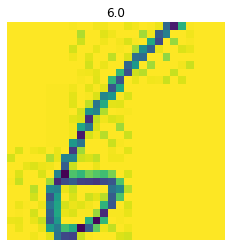

In [179]:
# Prepare Dataset
# load data
train = pd.read_csv(r"./new_data/result4.csv",dtype = np.float32)  

# split data into features(pixels) and labels(numbers from 0 to 9)
targets_numpy = train.label.values
features_numpy = train.loc[:,train.columns != "label"].values/255 # normalization

                    # : 처음부터끝까지 label이 아닌 column 전부 
                
    
# train test split. Size of train data is 80% and size of test data is 20%. 
features_train, features_test, targets_train, targets_test = train_test_split(features_numpy,
                                                                             targets_numpy,
                                                                             test_size = 0.2,
                                                                             random_state = 42) 

print(len(features_train))

# create feature and targets tensor for train set. As you remember we need variable to accumulate gradients. Therefore first we create tensor, then we will create variable
featuresTrain = torch.from_numpy(features_train)
targetsTrain = torch.from_numpy(targets_train).type(torch.LongTensor) # data type is long



#  ^  여기에서 tensor로 만든거임

print(featuresTrain.size())      # featuresTrain 은 33600 x 784 로 33600개의 사진의 정보를 가지고 있음
print(targetsTrain.size())       # targetsTrain 은 33600 개의 사진의 label을 가지고 있음 .



# create feature and targets tensor for test set.
# featuresTest = torch.from_numpy(features_test)
# targetsTest = torch.from_numpy(targets_test).type(torch.LongTensor) # data type is long



# Pytorch train and test sets
train = torch.utils.data.TensorDataset(featuresTrain,targetsTrain)
# test = torch.utils.data.TensorDataset(featuresTest,targetsTest)

# data loader
train_loader = torch.utils.data.DataLoader(train, batch_size = batch_size, shuffle = False)
test_loader = torch.utils.data.DataLoader(test, batch_size = batch_size, shuffle = False)

# visualize one of the images in data set
plt.imshow(features_numpy[10].reshape(28,28))         #features_numpy 는 현재 1x784 니까 그걸 28x28로 바꿈 
plt.axis("off")
plt.title(str(targets_numpy[10]))
plt.savefig('graph.png')
plt.show()

In [185]:
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(RNNModel, self).__init__()
        # Number of hidden dimensions
        self.hidden_dim = hidden_dim
        
        # Number of hidden layers
        self.layer_dim = layer_dim
        
        # RNN
        self.rnn = nn.RNN(input_dim, hidden_dim, layer_dim, batch_first=True, 
                          nonlinearity='relu')
        
        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim))       # variable로 만들고 
            
        # One time step
        out, hn = self.rnn(x, h0)       # rnn 한번 
        out = self.fc(out[:, -1, :]) 
        return out

# batch_size, epoch and iteration
batch_size = 100

num_epochs = 7

# Pytorch train and test sets
train = torch.utils.data.TensorDataset(featuresTrain,targetsTrain)
# test = torch.utils.data.TensorDataset(featuresTest,targetsTest)
print(len(train))
# data loader
train_loader = torch.utils.data.DataLoader(train, batch_size = batch_size, shuffle = False)
# test_loader = torch.utils.data.DataLoader(test, batch_size = batch_size, shuffle = False)
    
# Create RNN
input_dim = 28    # input dimension
hidden_dim = 100  # hidden layer dimension
layer_dim = 3     # number of hidden layers
output_dim = 19   # output dimension

model = RNNModel(input_dim, hidden_dim, layer_dim, output_dim)

# Cross Entropy Loss 
error = nn.CrossEntropyLoss()

# SGD Optimizer
learning_rate = 0.004
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

150984


In [198]:

seq_dim = 28  
loss_list = []
iteration_list = []
accuracy_list = []
count = 0
for epoch in range(4):
    for i, (images, labels) in enumerate(train_loader):    # train loader 에서 image와 label을 가져옴 

        train  = Variable(images.view(-1, seq_dim, input_dim))
        labels = Variable(labels )             
                                             # variable 변수로 바꿈 
            
        # Clear gradients
        optimizer.zero_grad()               # 초기화
        
        # Forward propagation
        outputs = model(train)           
        
        # Calculate softmax and ross entropy loss
        loss = error(outputs, labels)
        
        # Calculating gradients
        loss.backward()
        
        # Update parameters
        optimizer.step()
        
        count += 1
        
        if count % 250 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in train_loader:
                images = Variable(images.view(-1, seq_dim, input_dim))
                
                # Forward propagation
                outputs = model(images)
                
                # Get predictions from the maximum value
                predicted = torch.max(outputs.data, 1)[1]
                
                # Total number of labels
                total += labels.size(0)
                
                correct += (predicted == labels).sum()
            
            accuracy = 100 * correct / float(total)
            
            # store loss and iteration
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
            if count % 500 == 0:
                # Print Loss
                print('Iteration: {}  Loss: {}  Accuracy: {} %'.format(count, loss.data.item(), accuracy))

Iteration: 500  Loss: 0.10065943002700806  Accuracy: 96 %
Iteration: 1000  Loss: 0.17255908250808716  Accuracy: 95 %
Iteration: 1500  Loss: 0.14039181172847748  Accuracy: 95 %
Iteration: 2000  Loss: 0.129879891872406  Accuracy: 96 %
Iteration: 2500  Loss: 0.2768355906009674  Accuracy: 93 %
Iteration: 3000  Loss: 0.1444084495306015  Accuracy: 94 %
Iteration: 3500  Loss: 0.08490040153265  Accuracy: 95 %
Iteration: 4000  Loss: 0.15366744995117188  Accuracy: 95 %
Iteration: 4500  Loss: 0.049501948058605194  Accuracy: 95 %
Iteration: 5000  Loss: 0.1872931867837906  Accuracy: 96 %
Iteration: 5500  Loss: 0.07704690098762512  Accuracy: 96 %
Iteration: 6000  Loss: 0.10894027352333069  Accuracy: 96 %


In [199]:
torch.save(model.state_dict(),'./models/final3')

In [114]:
torch.save(model.state_dict(),'./models/model1')